In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
from matplotlib import pyplot as plt
import math

In [2]:
def complex_circle_uniform(norm, dim, num):
    vals = np.zeros((num, dim), dtype=np.complex_)
    for n in range(num): 
        for m in range(dim): 
            theta = np.random.uniform(0, 2*np.pi)
            real = norm*np.cos(theta)
            comp = norm*np.sin(theta)
            vals[n,m] = real + comp*1j

    return vals

def complex_circle_gauss(norm, mean, std, dim, num):
    vals = np.zeros((num, dim), dtype=np.complex_)
    for n in range(num): 
        for m in range(dim): 
            theta = np.random.normal(mean, std)
            real = norm*np.cos(theta)
            comp = norm*np.sin(theta)
            vals[n,m] = real + comp*1j

    return vals

def complex_disk(max_norm, dim, num):
    vals = np.zeros((size, dim), dtype=np.complex_)
    for n in range(num): 
        for m in range(dim): 
            theta = np.random.uniform(0, 2*np.pi)
            r = np.sqrt(np.random.uniform(0, norm))
            real = r*np.cos(theta)
            comp = r*np.sin(theta)
            vals[n,m] = real + comp*1j

    return vals

def complex_randist(norm_mean, norm_std, ang_mean, ang_std, dim, num): 
    vals = np.zeros((num, dim), dtype=np.complex_)
    for n in range(num): 
        for m in range(dim): 
            r = np.sqrt(np.abs(np.random.normal(norm_mean, norm_std)))
            theta = np.random.normal(ang_mean, ang_std)
            real = r*np.cos(theta)
            comp = r*np.sin(theta)
            vals[n,m] = real + comp*1j

    return vals

def complex_gauss(norm_std, dim, num): 
    vals = np.zeros((num, dim), dtype=np.complex_)
    for n in range(num): 
        for m in range(dim): 
            r = np.random.rayleigh(norm_std)
            theta = np.random.uniform(0, np.pi*2)
            real = r*np.cos(theta)
            comp = r*np.sin(theta)
            vals[n,m] = real + comp*1j

    return vals

def complex_stdgauss(mean=0, std=np.sqrt(1/2), dim=1, num=1000): 
    vals = np.zeros((num, dim), dtype=np.complex_)
    for n in range(num): 
        for m in range(dim):
            real = np.random.normal(mean, std)
            comp = np.random.normal(mean, std)
            vals[n,m] = real + comp*1j

    return vals

def complex_spiral(max_norm, dim, num):
    vals = np.zeros((num, dim), dtype=np.complex_)
    r = np.linspace(0, max_norm, num)
    theta = np.linspace(0, 2*np.pi, num)
    for n in range(num): 
        for m in range(dim): 
            ang = theta[n]
            norm = r[n]
            real = norm*np.cos(ang)
            comp = norm*np.sin(ang)
            vals[n,m] = real + comp*1j

    return vals

def complexMSELoss(z1, z2): 
    return torch.mean(torch.abs(z1-z2)**2)

In [3]:
dim, hidden_size = 1, [4]

class ExpActivation(nn.Module): 
    def __init__(self): 
        super().__init__()

    def forward(self, x): 
        return torch.exp(x)

class MLP(nn.Module): 
    def __init__(self, num_input, num_hidden, num_output): 
        super(MLP, self).__init__()
        layers = []
        for i in range(len(num_hidden)):
            if i == 0:
                layers.append(nn.Linear(num_input, num_hidden[i]))
            else: 
                layers.append(nn.Linear(num_hidden[i-1], num_hidden[i]))
            layers.append(ExpActivation())
        self.hidden = nn.Sequential(*layers)
        self.output = nn.Linear(num_hidden[-1], num_output)

    def forward(self, x): 
        x = self.hidden(x)
        x = self.output(x)

        return x

class NeuralNet(nn.Module): 
    def __init__(self): 
        super(NeuralNet, self).__init__()
        layer1 = MLP(dim, hidden_size, dim)
        self.fnn = layer1

    def forward(self, x): 
        x = self.fnn(x)

        return x

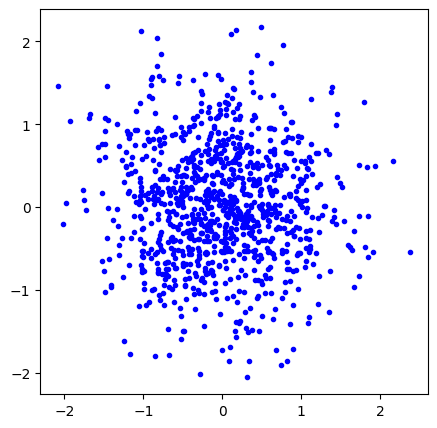

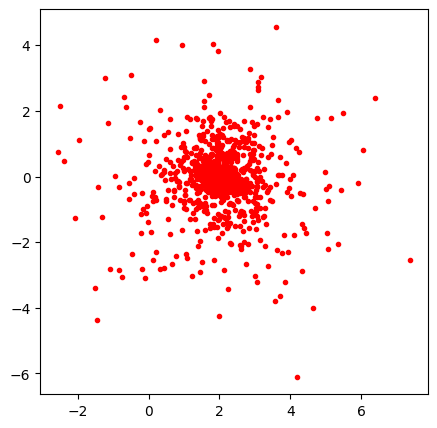

In [4]:
polynomial = np.polynomial.Polynomial([2, 0, 1])
# mu, stdev, dim, test_len = 0, np.sqrt(1/2), 1, 1000
test_len = 1000
xtest_stdgauss = complex_stdgauss()
ytest_stdgauss = polynomial(xtest_stdgauss)
plt.figure(figsize=(5,5))
plt.plot(xtest_stdgauss.real, xtest_stdgauss.imag, 'b.')
plt.show()

plt.figure(figsize=(5,5))
plt.plot(ytest_stdgauss.real, ytest_stdgauss.imag, 'r.')
plt.show()

xtest_stdgauss = torch.tensor(xtest_stdgauss, dtype=torch.complex64).reshape(test_len, 1, dim)
ytest_stdgauss = torch.tensor(ytest_stdgauss, dtype=torch.complex64).reshape(test_len, 1, dim)

### Model 1 trained from a disk with UD

In [5]:
model1 = NeuralNet()
model1.type(torch.complex64)
PATH1 = "state_dict_disk.pt"
model1.load_state_dict(torch.load(PATH1))
model1.eval()

with torch.no_grad():
    for name, param in model1.named_parameters():
        print(f"name:{name} parameters:{param}")

name:fnn.hidden.0.weight parameters:Parameter containing:
tensor([[-0.9489+0.3438j],
        [-0.6559-1.1207j],
        [ 1.0275-0.2584j],
        [ 0.8561+1.1150j]], requires_grad=True)
name:fnn.hidden.0.bias parameters:Parameter containing:
tensor([-0.0131-0.1075j, -1.0844-0.2293j,  0.0369+0.0902j, -1.0949-0.2210j],
       requires_grad=True)
name:fnn.output.weight parameters:Parameter containing:
tensor([[ 0.5248+0.3701j, -0.0044-0.7025j,  0.5600+0.0910j,  0.2340-0.4995j]],
       requires_grad=True)
name:fnn.output.bias parameters:Parameter containing:
tensor([0.8878-0.0429j], requires_grad=True)


tensor(0.0125)


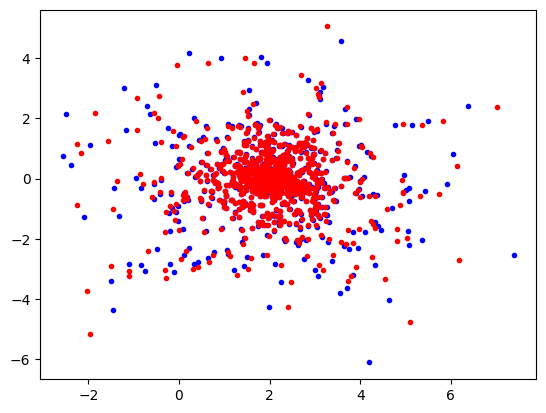

In [6]:
with torch.no_grad(): 
    true, preds = ytest_stdgauss, model1(xtest_stdgauss)
    print(complexMSELoss(true, preds))
    true, preds = torch.Tensor.numpy(ytest_stdgauss).reshape(test_len, dim), torch.Tensor.numpy(model1(xtest_stdgauss)).reshape(test_len, dim)

true_real, true_comp = true.real, true.imag
preds_real, preds_comp = preds.real, preds.imag

plt.plot(true_real, true_comp, 'b.')
plt.plot(preds_real, preds_comp, 'r.')
plt.show()

### Model 2 trained from a circle with UD

In [7]:
model2 = NeuralNet()
model2.type(torch.complex64)
PATH2 = "state_dict_circle.pt"
model2.load_state_dict(torch.load(PATH2))
model2.eval()

with torch.no_grad():
    for name, param in model2.named_parameters():
        print(f"name:{name} parameters:{param}")

name:fnn.hidden.0.weight parameters:Parameter containing:
tensor([[ 0.4510+0.5736j],
        [-0.5799+0.5260j],
        [-0.6370-0.4242j],
        [ 0.5247-0.3897j]], requires_grad=True)
name:fnn.hidden.0.bias parameters:Parameter containing:
tensor([-0.7610+0.3265j, -0.9147+0.9077j, -0.9570-0.2848j, -0.0786+0.6353j],
       requires_grad=True)
name:fnn.output.weight parameters:Parameter containing:
tensor([[-1.1020-1.4173j,  1.7022+0.7892j,  1.7749-1.4988j,  1.3157+0.9565j]],
       requires_grad=True)
name:fnn.output.bias parameters:Parameter containing:
tensor([1.1548-0.6254j], requires_grad=True)


tensor(0.0032)


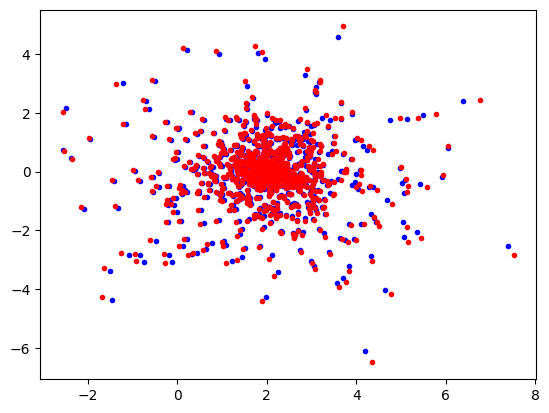

In [8]:
with torch.no_grad(): 
    true, preds = ytest_stdgauss, model2(xtest_stdgauss)
    print(complexMSELoss(true, preds))
    true, preds = torch.Tensor.numpy(ytest_stdgauss).reshape(test_len, dim), torch.Tensor.numpy(model2(xtest_stdgauss)).reshape(test_len, dim)

true_real, true_comp = true.real, true.imag
preds_real, preds_comp = preds.real, preds.imag

plt.plot(true_real, true_comp, 'b.')
plt.plot(preds_real, preds_comp, 'r.')
plt.show()

### Model 3 trained from a spiral

In [9]:
model3 = NeuralNet()
model3.type(torch.complex64)
PATH3 = "state_dict_spiral.pt"
model3.load_state_dict(torch.load(PATH3))
model3.eval

with torch.no_grad():
    for name, param in model3.named_parameters():
        print(f"name:{name} parameters:{param}")

name:fnn.hidden.0.weight parameters:Parameter containing:
tensor([[ 0.9085+0.2885j],
        [-1.0223+0.1257j],
        [-0.0619-0.0352j],
        [ 0.8973+0.0330j]], requires_grad=True)
name:fnn.hidden.0.bias parameters:Parameter containing:
tensor([-0.2515+0.0264j,  0.8376-0.0055j,  0.2295-0.0087j,  0.8295-0.0233j],
       requires_grad=True)
name:fnn.output.weight parameters:Parameter containing:
tensor([[0.2762-0.0297j, 0.4167+0.0568j, 0.1617-0.0124j, 0.3930-0.0349j]],
       requires_grad=True)
name:fnn.output.bias parameters:Parameter containing:
tensor([-0.2973+0.0022j], requires_grad=True)


tensor(0.1649)


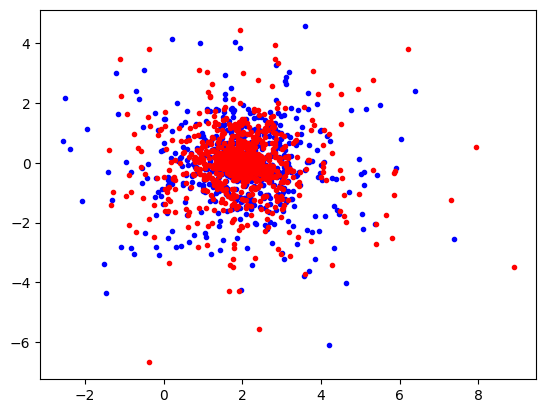

In [10]:
with torch.no_grad(): 
    true, preds = ytest_stdgauss, model3(xtest_stdgauss)
    print(complexMSELoss(true, preds))
    true, preds = torch.Tensor.numpy(ytest_stdgauss).reshape(test_len, dim), torch.Tensor.numpy(model3(xtest_stdgauss)).reshape(test_len, dim)

true_real, true_comp = true.real, true.imag
preds_real, preds_comp = preds.real, preds.imag

plt.plot(true_real, true_comp, 'b.')
plt.plot(preds_real, preds_comp, 'r.')
plt.show()

### Model 4 trained from a circle with ND

In [11]:
model4 = NeuralNet()
model4.type(torch.complex64)
PATH4 = "state_dict_circle_gauss.pt"
model4.load_state_dict(torch.load(PATH4))
model4.eval()

with torch.no_grad():
    for name, param in model4.named_parameters():
        print(f"name:{name} parameters:{param}")

name:fnn.hidden.0.weight parameters:Parameter containing:
tensor([[ 0.7667-0.7256j],
        [-0.8514-0.3855j],
        [ 1.0588+0.5941j],
        [-1.3519+1.0431j]], requires_grad=True)
name:fnn.hidden.0.bias parameters:Parameter containing:
tensor([ 0.0289+0.2984j,  0.1022-0.3188j, -0.3087+0.3984j, -1.8692-0.3004j],
       requires_grad=True)
name:fnn.output.weight parameters:Parameter containing:
tensor([[0.3074+0.3136j, 0.6935-0.1581j, 0.1497-0.5118j, 0.1599+0.6318j]],
       requires_grad=True)
name:fnn.output.bias parameters:Parameter containing:
tensor([0.8198+0.2198j], requires_grad=True)


tensor(0.0224)


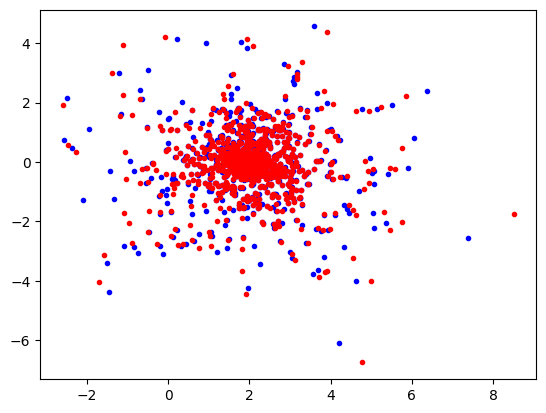

In [12]:
with torch.no_grad(): 
    true, preds = ytest_stdgauss, model4(xtest_stdgauss)
    print(complexMSELoss(true, preds))
    true, preds = torch.Tensor.numpy(ytest_stdgauss).reshape(test_len, dim), torch.Tensor.numpy(model4(xtest_stdgauss)).reshape(test_len, dim)

true_real, true_comp = true.real, true.imag
preds_real, preds_comp = preds.real, preds.imag

plt.plot(true_real, true_comp, 'b.')
plt.plot(preds_real, preds_comp, 'r.')
plt.show()

### Standard Noraml 

In [14]:
model5 = NeuralNet()
model5.type(torch.complex64)
PATH5= "state_dict_disk_gauss.pt"
model5.load_state_dict(torch.load(PATH5))
model5.eval()

with torch.no_grad():
    for name, param in model5.named_parameters():
        print(f"name:{name} parameters:{param}")

name:fnn.hidden.0.weight parameters:Parameter containing:
tensor([[-0.4628+0.5548j],
        [ 0.5436+0.4931j],
        [ 0.3527-0.5488j],
        [-0.5916-0.3473j]], requires_grad=True)
name:fnn.hidden.0.bias parameters:Parameter containing:
tensor([-0.3724+0.8065j, -0.4482+1.0191j,  0.1522-0.4653j, -0.2196-0.2826j],
       requires_grad=True)
name:fnn.output.weight parameters:Parameter containing:
tensor([[ 0.7846+1.0506j, -1.2167-0.8277j, -0.8552+0.7802j,  0.9157-0.7301j]],
       requires_grad=True)
name:fnn.output.bias parameters:Parameter containing:
tensor([2.0374-0.4362j], requires_grad=True)


tensor(0.0008)


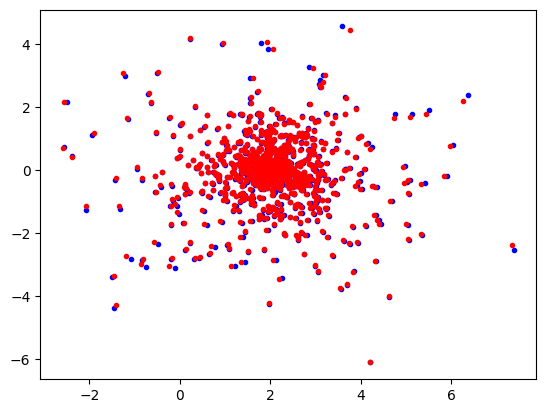

In [16]:
with torch.no_grad(): 
    true, preds = ytest_stdgauss, model5(xtest_stdgauss)
    print(complexMSELoss(true, preds))
    true, preds = torch.Tensor.numpy(ytest_stdgauss).reshape(test_len, dim), torch.Tensor.numpy(model5(xtest_stdgauss)).reshape(test_len, dim)

true_real, true_comp = true.real, true.imag
preds_real, preds_comp = preds.real, preds.imag

plt.plot(true_real, true_comp, 'b.')
plt.plot(preds_real, preds_comp, 'r.')
plt.show()